<h1>Modified Base Tutorial</h1>

The modified base tutorial is intended as a simple guide for handling the modified-base information output by the Guppy basecaller. We will walk through the data provided in the `.bam` file output by Guppy and demonstrate how to convert this this data to per locus modified-base frequencies.

The tutorial is provided with a sample dataset for chromosome 20 of the GIAB NA24385 sample, and the workflow can be used to address such questions as:

* How can CpG related 5mC base-modifications be extracted from basecaller outputs.
* Where in the genome do these base-modifications occur?
* How prevalent are base-modifications at given genomic locations?

Methods used in this tutorial include:

- Python for statistical analysis and reporting, including  use of [`pandas`](https://pandas.pydata.org/), [`numpy`](https://numpy.org/), and [`bokeh`](https://docs.bokeh.org/en/latest/index.html), 
- Programs and Python code from [`modbam2bed`](https://github.com/epi2me-labs/modbam2bed) for processing `.bam` files with modified base data.

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 8 Gb RAM

⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed.


## Getting started

To start analysing our experiment we must first collate our data. The workflow below expects to be given a single data folder. It will search this folder to find `.fast5` files containing modified base data from the Guppy basecaller.

Before anything else we will create and set a working directory:

In [24]:
# create a work directory and move into it
tutorial_name = 'modbase_tutorial'
working_dir = '/epi2melabs/{}'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

from epi2melabs import ping
pinger = ping.Pingu()
response = pinger.send_notebook_ping('start', 'modified_base_tutorial')

/epi2melabs/modbase_tutorial


### Install additional software

This tutorial uses a couple of software packages that are not included in the default **EPI2ME Labs** server. Below we will install:

* the [modbampy](https://pypi.org/project/modbampy/) package for manipulating Guppy's BAM files containing modified base information.
* the [modbam2bed](https://github.com/epi2me-labs/modbam2bed) program for converting Guppy's BAM files to BED files.

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

In [ ]:
# install fast5mod for manipulating and summarising guppy information
!pip install modbampy
!mamba install -q -y modbam2bed

### Sample Data

To use this tutorial with sample data we can download the files using the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!echo 'Downloading `.bam` data...'
!wget "$site"/modbase_tutorial/chr20.bam
!wget "$site"/modbase_tutorial/chr20.bam.bai
!mkdir -p "sample_data" && mv chr20.bam* sample_data

For our analysis we will also need the human genome reference:

In [ ]:
!wget "$site"/grch38.tar.gz
!tar -xzvf grch38.tar.gz

The reference contained within the above download is that which can also be obtained [here](http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz), the reasons for using this file are presented in Heng Li's [blog post](https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use).

The sample data taken from our [ONT Open Datasets](https://labs.epi2me.io/dataindex/) archive. The full dataset comprises MinION sequencing runs, the data used here has been prefiltered to reads derived from human chromosome 20 to provide a small example dataset.

To view the outcome of the download we can use the `tree` command to show the contents of the working directory:

In [26]:
!tree .

.
├── analysis
│   └── guppy.cpg.bam
├── grch38
│   ├── grch38.fasta.gz
│   ├── grch38.fasta.gz.fai
│   ├── grch38.fasta.gz.gzi
│   └── README
├── grch38.tar.gz
├── guppy.cpg.bam
└── sample_data
    ├── chr20.bam
    └── chr20.bam.bai

3 directories, 9 files


The files should also appear in the File Browser to the left-hand side of the screen.

### Modified base base-calling

The Guppy basecaller software includes a model for the detection of base modifications. The version of Guppy at the time of writing (5.0.12) supports modifications that include 5mC in a [CpG context](https://en.wikipedia.org/wiki/CpG_site), [Dcm](https://en.wikipedia.org/wiki/DNA_methylation#In_bacteria) (5mC motifs CCAGG and CCTGG) and [Dam](https://en.wikipedia.org/wiki/Dam_methylase), m6A GATC motif.

By default, Guppy will not produce modified base statistics in its outputs. In order to obtain these it is necessary to use an non-default configuration file and enable the alignment output. For example one should run a command such as:

```
guppy_basecaller \
    --config dna_r9.4.1_450bps_modbases_5mc_hac.cfg \
    --device cuda:0 \
    --bam_out --recursive --compress \
    --align_ref <reference fasta> \
    -i <fast5 input directory> -s <output directory>

```

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the values in the form below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

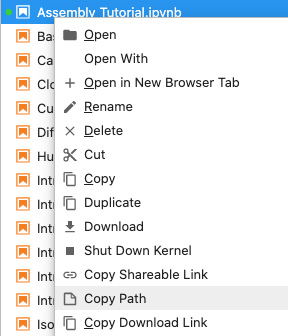

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below. After updating the values, be sure to press the `> Enter` button.

In [ ]:
from epi2melabs.notebook import InputForm, InputSpec

data_folder = None
output_folder = None
reference_genome = None

def process_form(inputs):
    global data_folder
    global output_folder
    global reference_genome
    # make sure all bams are indexed
    data_folder = inputs.data_folder
    if inputs.force_bam_index:
        !echo "Ensuring .bams are indexed"
        !find $data_folder -name "*.bam" | xargs -I {} samtools index {}
    !echo "Making output folder"
    output_folder = inputs.output_folder
    !mkdir -p "$output_folder"
    reference_genome = inputs.reference_genome
    !test -f "$reference_genome" \
        && echo "Reference file found" \
        || cecho error "WARNING: Reference file does not exist"


input_form = InputForm(
    InputSpec('data_folder', 'Input folder', 'sample_data',long_desc="Guppy/MinKNOW output directory, will be searched for BAM files:"),
    InputSpec('force_bam_index', 'Index BAMs', True, long_desc="Some versions of Guppy do not write required BAM indexes tick this box to force indexing:"),
    InputSpec('output_folder', 'Output folder', 'analysis', long_desc="Output location:"),
    InputSpec('reference_genome', 'Reference .fasta', 'grch38/grch38.fasta.gz', long_desc="Location of reference genome:"))
input_form.add_process_button(process_form)
input_form.display()

## Summarising the data

In order to enable further analysis we will first summarise the data from Guppy's basecalling outputs. There are two steps to this process. We will extract pertinent information from the `.fast5` files, align the sequencing reads to the reference sequence, and store the results in a `.bam` alignment file. In a second step we will create a per-reference position summary of the data.

### Creating a tabular summary

With our sequencing data in a `.bam`, we can proceed to analyse the data with standard bioinformatics tools.

After basecalling, which can be performed live during the sequencing run, a simple one
step process can be used to summarize the BAM files into methylated and unmethylated frequency information
akin to that obtained for bisulfite sequencing using pacakges such as bismark. For this we use our recently developed
[modbam2bed](https://github.com/epi2me-labs/modbam2bed) program:

In [27]:
bedmethyl = os.path.join(output_folder, "guppy.cpg.bam")
!modbam2bed -e -m 5mC --cpg -t 4 -r chr20 $reference_genome $data_folder/*.bam > $bedmethyl

Analysing: 5-methylcytosine (5mC, C>m)
Processing: chr20:0-64444167
100 %  


Here the option `-m 5mC` instructs the program to examine 5-methylcytosine presence, while the option `--cpg` indicates that only loci containing the sequence motif `CG` should be output. Other choices can be found by running:

In [ ]:
!modbam2bed --help

The output file `guppy.cpg.bam` is formatted as a bedMethyl file, which is a simple tab-separated text file that can be read with pandas:

In [51]:
# Modified base summary parsing (click play)

import os
import pandas as pd

methdata = pd.read_csv(
    bedmethyl, sep='\t',
    header=None,
    names=["chrom", "start", "end", "name", "score", "strand", "tstart", "tend", "color", "coverage", "freq", "canon", "mod", "filt"])
methdata.head()

,chrom,start,end,name,score,strand,tstart,tend,color,coverage,freq,canon,mod,filt
0,chr20,60008,60009,5mC,1000,+,60008,60009,"0,0,0",4,25.0,3,1,0
1,chr20,60009,60010,5mC,1000,-,60009,60010,"0,0,0",1,0.0,1,0,0
2,chr20,60119,60120,5mC,1000,+,60119,60120,"0,0,0",4,0.0,4,0,0
3,chr20,60120,60121,5mC,1000,-,60120,60121,"0,0,0",1,0.0,1,0,0
4,chr20,60578,60579,5mC,833,+,60578,60579,"0,0,0",12,30.0,7,3,0


The column names should be self explanatory. The first three columns denote simply: the reference sequence (`chrom`) and the `start` and `end` positions (invariably one apart). The next column indicates the `name` of the modified base analysis, the `score` column indicates the reliability of the result and is described in the `modbam2bed` documentation. The `strand` columns indicated on which strand of the reference the modification is found. `tstart`, `tend`, and `color` are part of the Encode project description of the bedMethyl format but can be ignored. The `coverage` column indicates the number of reads spanning the locus while `freq` indicates the modification frequency (percentage of reads with modification). The `canon`, `mod`, and `filt` columns indicate the absolute count of reads containing the canonical base associated with the modification, the count of reads with the modified base, and the number of ambiguous (filtered) reads. The `coverage` column is not the sum of these final three columns as it also includes reads with deletions and substitutions at the locus of interest.

## Analysis of the summary data

In this section we will perform some basic analysis of the summary count data. From this table alone interesting observations can be made.


### Aggregated methylation status

We will start our analysis by further summarising the summary table to pull out
average methylation rates and examine potential strand bias.

We start by assessing the coverage of our candidate modified-base sites:

In [54]:
# Coverage plot code (click play)
import aplanat
from aplanat import hist

names = ('fwd', 'rev')
fwdmeth = methdata.loc[methdata['strand'] == "+"]
revmeth = methdata.loc[methdata['strand'] == "-"]
plot = hist.histogram(
    [x["coverage"] for x in (fwdmeth, revmeth)],
    colors=['maroon', 'darkolivegreen'], names=names,
    binwidth=1, style='line', title='Coverage distribution',
    xlim=(0,100))
plot.xaxis.axis_label = 'coverage'
plot.yaxis.axis_label = 'frequency'
aplanat.show(plot, background='#F4F4F4')

We can use the bulk coverage data to determine a filter to exclude sites with lower than expected coverage, as these may skew our observations.

The following summarises methylation status across the dataset:

In [84]:
# Methylation summary plot code (click play)
coverage_mask =  10

from bokeh.layouts import gridplot
from aplanat import annot

# join the reverse to the fwd assuming sites are one apart
print("Joining forward and reverse strand joins assuming 1-base offset.")
tmp = revmeth.copy()
tmp['start'] -= 1
tmp['end'] -= 1
methjoin = pd.merge(fwdmeth, tmp, on=("chrom", "start"), suffixes=(".fwd", ".rev"))
methjoin["coverage"] = methjoin["coverage.fwd"] + methjoin["coverage.rev"]

# proportion by site
p1 = hist.histogram(
    [methdata['freq']],
    colors=['steelblue'], xlim=(0, 100),
    bins=200, title='Methylation proportion by site')
p1.xaxis.axis_label = 'methylation proportion'
p1.yaxis.axis_label = 'frequency'

# strand bias - remove the trivial case
bias = methjoin['freq.fwd'] - methjoin['freq.rev']
bias = bias.loc[(bias<50) & (bias>-50)]
p2 = hist.histogram(
    [bias], colors=['steelblue'], bins=50,
    title="Methylation strand bias by site.")
p2.xaxis.axis_label = '(fwd. meth. prop.) - (rev. meth. prop.)'
p2.yaxis.axis_label = 'frequency'

aplanat.show(gridplot([[p1, p2]]) , background='#F4F4F4')

Joining forward and reverse strand joins assuming 1-base offset.


### Assessing methylation locality

It is known that [CpG sites](https://en.wikipedia.org/wiki/CpG_site) occur less frequently than random chance in the human genome, and that further the sites which do exist tend to be clustered in so-called CpG islands. These islands typically occur at transcription start sites, and it is found that methylation rates in CpG islands are low for genes which are suppressed. To enable analysis of these effects we can plot the summary data according to genomic coordinates.

To plot a coverage trace across a reference sequence use the form below. This allows exploration of position dependent modified-base rates and any strand biases present.

In [85]:
# Coverage plot code
from aplanat import points
import ipywidgets as widgets

def plot_callback(inputs):
    try:
        chrom, coords = inputs.region.split(":")
        start, stop = (int(x) for x in coords.split("-"))
    except Exception as e:
        print('Cannot parse region as "chrom:start-stop".')

    # filter data by inputs
    select = (
        (methjoin['coverage'] >= inputs.coverage_mask) &
        (methjoin['chrom'] == chrom) & 
        (methjoin['start'] > start) & 
        (methjoin['start'] < stop))
    d = methjoin.loc[select]

    def down_sample(df, plot_limit=350000):
        # if we have a lot of points, remove some to avoid bokeh dying.
        if len(df) > plot_limit:
            display("Warning: Downsampling points to {} entries. Select a smaller region to show all points.".format(plot_limit))
            df = df.sample(n=plot_limit)
        else:
            display("Showing all sites.")
        return df

    # create a plot
    title = '{} coverage'.format(inputs.region)

    if inputs.colour_by == "orientation":
        d = down_sample(d, plot_limit=350000)
        xs = [d['start']] * 2
        ys = [d['coverage.fwd'], -d['coverage.rev']]
        colors=['maroon', 'orange']
        names=['fwd', 'rev']
    elif inputs.colour_by == "mod. status":
        d = down_sample(d, plot_limit=350000)
        xs = [d['start']] * 2
        ys = [
            +d['mod.fwd'] + d['mod.rev'],
            -d['canon.rev'] - d['canon.rev']]
        colors = ['blue', 'green']
        names = ['modified', 'canonical']
    elif inputs.colour_by == "both":
        d = down_sample(d, plot_limit=125000)
        xs = [d['start']] * 4
        title += ' Positive: fwd strand, Negative: rev strand'
        ys = [
            +d['mod.fwd'], +d['canon.fwd'],
            -d['mod.rev'], -d['canon.fwd']]
        colors = ['blue', 'green', 'blue', 'green']
        names = ['modified', 'canonical', None, None] 
    else:
        raise ValueError("Unrecognised 'colour_by'.")

    plot = points.points(
        xs, ys, colors=colors, names=names, height=300, width=1200)
    plot.xaxis.formatter.use_scientific = False
    plot.xaxis.axis_label = 'position'
    plot.yaxis.axis_label = 'frequency'
    aplanat.show(plot, background='#F4F4F4')


plot_form = InputForm(
    InputSpec("region", "Region", "chr20:0-65000000"),
    InputSpec("colour_by", "Colour by",["mod. status", "orientation", "both"]),
    InputSpec("coverage_mask", "Coverage mask", widgets.IntText(10)))
plot_form.add_process_button(plot_callback)
plot_form.display()

## Comparison to Bisulphite sequencing data

As a technology demonstrator this section of the tutorial shows an approach through which the Guppy-based base-modification information can be compared with data from Bisulphite sequencing experiments.

> The bisulphite data used in this analysis has been sourced from the same GM24385 cell line. The data were derived from the same sample extraction as the nanopore data. See
> [Detection of 5-methylcytosine modification in GM24385](http://labs.epi2me.io/gm24385-5mc/) for more details.

The bisulphite data can be downloaded using:

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!echo 'Downloading bisulfite data...'
!wget "$site"/modbase_tutorial/chr20.bismark.bed.gz

and read with pandas:

In [82]:
# Reading bisulfite data from bismark
bis = pd.read_csv(
    "chr20.bismark.bed.gz",
    sep="\t", header=None,
    names=['chrom', 'start', 'end', 'freq', 'mod', 'canon'])
bis.head()

,chrom,start,end,freq,mod,canon
0,chr20,60008,60009,14.285714,1,6
1,chr20,60009,60010,0.000000,0,9
2,chr20,60119,60120,0.000000,0,37
3,chr20,60120,60121,0.000000,0,57
4,chr20,60578,60579,47.368421,9,10


We can depict the concordance between the methylation frequencies using a heat map:

In [83]:
# Methylation Comparison plot code (click play)
import numpy as np
from aplanat import spatial

combined = pd.merge(bis, methdata, how="outer", on=["chrom", "start", "end"], suffixes=[".bis", ".nano"])

plot_data = combined.loc[
    (combined['mod.bis'] + combined['canon.bis'] > 10) &
    (combined['coverage'] > 10)]
r_coeff = np.corrcoef(plot_data['freq.bis'], plot_data['freq.nano'])
r_coeff = r_coeff[0,1]

p = spatial.heatmap2(
    plot_data['freq.bis'], plot_data['freq.nano'],
    tools = "pan,wheel_zoom,box_zoom,reset",
    log=True, x_bins=50, y_bins=50, xlim=(0,100), ylim=(0,100), zlim=(100, 100000),
    title="Methylation comparison. R={:.3f}".format(r_coeff))

# match_aspect doesn't seem to work as described...
p.match_aspect = True
p.aspect_ratio = 1.2
p.xaxis.axis_label = 'Bisulphite Methylation Frequency'
p.yaxis.axis_label = 'Nanopore Methylation Frequency'
p.toolbar.logo = None
aplanat.show(p)

_ = pinger.send_notebook_ping('stop', 'modified_base_tutorial')

## Next steps

This tutorial has stepped through basic handling of the modified-base output from the Guppy basecaller. We have seen how to aggregate read data into a `.bam` alignment file for easy processing. Having aggregated read data we have performed some cursory analysis to motivate and guide further targetted investigation.

Users might also be interested in the following packages to help guide further exploration of their data:

* [methplotlib](https://github.com/wdecoster/methplotlib), generates a browser view for methylation data
* [pycoMeth](https://a-slide.github.io/pycoMeth/), DNA methylation analysis downstream of Nanopolish